[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_ZpVdMxSJ5NcLM119HNmbKuI8a7NE2T0)

# Daytrade stock chooser

## What will happen here?

I'll download historical data of 10 stocks. A prediction model will try to predict, throught RNN models, the next value of each one of them and then, using the knapsack problem, I'll choose 3 to invest today (let's pretend today is 28/02) so I have the highest possible gain tomorrow.

## Solution

### Installation of the libraries to be used

In [1]:
%pip install -U mip yfinance requests pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing the library elements that will be used

In [2]:
from mip import Model, maximize, xsum, BINARY, OptimizationStatus
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### Getting the stocks data

#### getting the list of stocks from the web

In [3]:
url = "https://investnews.com.br/financas/veja-a-lista-completa-dos-bdrs-disponiveis-para-pessoas-fisicas-na-b3/"
r = requests.get(url)
html = r.text
df_stocks = pd.read_html(html, header=0)[0]
df_stocks.head(10)

,EMPRESA,CÓDIGO,SETOR,PAÍS DE ORIGEM
0,3M,MMMC34,Indústria diversificada,EUA
1,AB INBEV,ABUD34,Bebidas,Bélgica
2,ABB LTD,A1BB34,Industrial,Switzerland
3,ABBOTT,ABTT34,Farmacêuticos,EUA
4,ABBVIE,ABBV34,Medicamentos e Outros Produtos,EUA
5,ABIOMED INC,A1BM34,Saúde,EUA
6,ACTIVISION,ATVI34,Tecnologia,EUA
7,ADOBE INC,ADBE34,Tecnologia,EUA
8,ADVANCE AUTO PARTS INC,A1AP34,Peças Automotivas,EUA
9,ADVANCED MIC,A1MD34,Tecnologia,EUA


#### getting 10 Close Value histories from stocks I chose from the list

In [4]:
ticker_list = ['GOGL35.SA', 'AAPL34.SA', 'CSCO34.SA', 'NFLX34.SA', 'HSHY34.SA', 'EBAY34.SA', 'ITLC34.SA', 'GPSI34.SA', 'GEOO34.SA', 'JPMC34.SA']
stocks_hist = yf.download(ticker_list, start='2018-01-01', end='2023-03-01')[['Close']]
stocks_hist.tail()

[*********************100%***********************]  10 of 10 completed


Close                                                \
            AAPL34.SA  CSCO34.SA   EBAY34.SA   GEOO34.SA  GOGL35.SA   
Date                                                                  
2023-02-22  38.270000  50.560001  126.250000  434.200012  39.430000   
2023-02-23  38.099998  50.500000  117.010002  423.799988  38.880001   
2023-02-24  37.980000  50.500000  117.010002  434.140015  38.529999   
2023-02-27  38.349998  50.580002  118.489998  437.500000  38.889999   
2023-02-28  38.599998  50.779999  119.680000  442.950012  39.299999   

                                                                    
            GPSI34.SA   HSHY34.SA  ITLC34.SA  JPMC34.SA  NFLX34.SA  
Date                                                                
2023-02-22  68.099998  247.759995  21.809999  71.099998  34.450001  
2023-02-23  66.540001  247.759995  21.840000  71.410004  32.980000  
2023-02-24  68.059998  247.759995  21.709999  72.959999  33.150002  
2023-02-27  69.489998  249.000000  21.549999  73.760002  33.500000  
2023-02-28  68.720001  249.000000  21.540001  74.650002  33.799999

##### creating list of dicts with each ticker and its respective history

In [5]:
stocks = []

for ticker in ticker_list:
  stocks.append({
      'ticker': ticker,
      'history': stocks_hist['Close'][ticker].values.tolist()
  })

##### normalizing the histories

In [6]:
x = np.arange(1,len(stocks[0]['history'])+1,1)

for obj in stocks:
  min = np.min(obj['history'])
  max = np.max(obj['history'])
  obj['history'] = (obj['history'] - min)/(max - min)

##### ploting the stocks histories

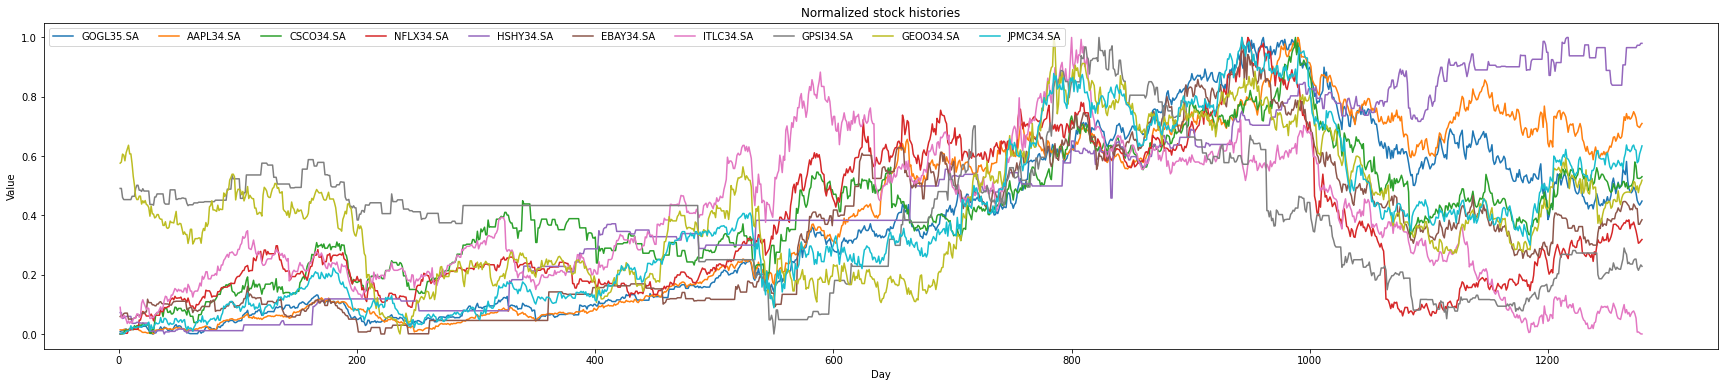

In [7]:
plt.figure(figsize=(30,6))
plt.title('Normalized stock histories')
plt.xlabel('Day')
plt.ylabel('Value')

for obj in stocks:
  plt.plot(x, obj['history'], label=obj['ticker'])

plt.legend(ncol=len(stocks))
plt.show()

#### preparing for training

In [8]:
train = {}
test = {}

for obj in stocks:
  training_rate = 0.8
  training_size = int(training_rate*(len(x)));

  train_x = x[0:training_size] 
  test_x = x[training_size:]

  train_y = obj['history'][0:training_size]
  test_y = obj['history'][training_size:]

  train[obj['ticker']] = np.array(list(zip(train_x, train_y)))
  test[obj['ticker']] = np.array(list(zip(test_x, test_y)))

#### Organizing data model

In [9]:
def create_dataset(n_X, look_back):
  dataX = []
  dataY = []
  for i in range(len(n_X)-look_back):
    a = n_X[i:(i+look_back), ]
    print('a: {}'.format(a))
    dataX.append(a)
    dataY.append(n_X[i + look_back, ])
  print('dataX: {}'.format(dataX))
  return np.array(dataX), np.array(dataY)

In [10]:
def prepare_data(series, look_back):
  X, y =[],[]
  n = len(series)
  for i in range(n - look_back):
    end = i + look_back
    if end <= n:
      seq_x = series[i:end,1]
      seq_y = series[end,1]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

#### Data structure

In [11]:
train_x = {}
test_x = {}
train_y = {}
test_y = {}

for ticker in ticker_list:
  look_back = 2
  local_train_x, train_y[ticker] = prepare_data(train[ticker], look_back)
  local_test_x, test_y[ticker] = prepare_data(test[ticker], look_back)

  n_features = 1 #monovariate series
  train_x[ticker] = local_train_x.reshape((local_train_x.shape[0], 
                              local_train_x.shape[1], 
                              n_features))
  test_x[ticker] = local_test_x.reshape((local_test_x.shape[0], 
                        local_test_x.shape[1], 
                        n_features))

#### Creating the RNN model

In [12]:
model = {}

for ticker in ticker_list:
  steps = train_x[ticker].shape[1]
  n_features = train_x[ticker].shape[2]
  epochs = 20
  units = 100
  tf.random.set_seed(8888) # Setting seed to ensure reproducibility.
  model[ticker] = Sequential()
  input_layer=(steps, n_features)
  model[ticker].add(LSTM(units, 
                return_sequences = True, 
                input_shape = input_layer))
  model[ticker].add(Dropout(0.2))
  model[ticker].add(LSTM(128,
                input_shape = input_layer))
  model[ticker].add(Dense(1))


In [13]:
for ticker in ticker_list:
  print('\n----------')
  print(ticker)
  print(model[ticker].summary())


----------
GOGL35.SA
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 2, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 158,177
Trainable params: 158,177
Non-trainable params: 0
_________________________________________________________________
None

----------
AAPL34.SA
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape    

#### hyperparameters choosing

In [14]:
for ticker in ticker_list:
  model[ticker].compile(loss = 'mean_squared_error', 
              optimizer = 'adam')

#### model training

In [15]:
history = {}

for ticker in ticker_list:
  history[ticker] = model[ticker].fit(train_x[ticker], train_y[ticker],
                       epochs = epochs,
                       batch_size = 70,
                       verbose = False,
                       shuffle = False,
                       validation_split = 0.3)

  hist = pd.DataFrame(history[ticker].history)
  hist.head()

In [16]:
for ticker in ticker_list:
  print(f'\n{ticker}')
  model[ticker].evaluate(test_x[ticker], test_y[ticker], batch_size=64)


GOGL35.SA
4/4 [==============================] - 0s 7ms/step - loss: 0.0013

AAPL34.SA
4/4 [==============================] - 0s 7ms/step - loss: 8.7775e-04

CSCO34.SA
4/4 [==============================] - 0s 7ms/step - loss: 7.5236e-04

NFLX34.SA
4/4 [==============================] - 0s 6ms/step - loss: 4.7352e-04

HSHY34.SA
4/4 [==============================] - 0s 8ms/step - loss: 0.0032

EBAY34.SA
4/4 [==============================] - 0s 7ms/step - loss: 4.3624e-04

ITLC34.SA
4/4 [==============================] - 0s 7ms/step - loss: 6.3771e-04

GPSI34.SA
4/4 [==============================] - 0s 7ms/step - loss: 3.0238e-04

GEOO34.SA
4/4 [==============================] - 0s 7ms/step - loss: 7.0158e-04

JPMC34.SA
4/4 [==============================] - 0s 7ms/step - loss: 7.5638e-04


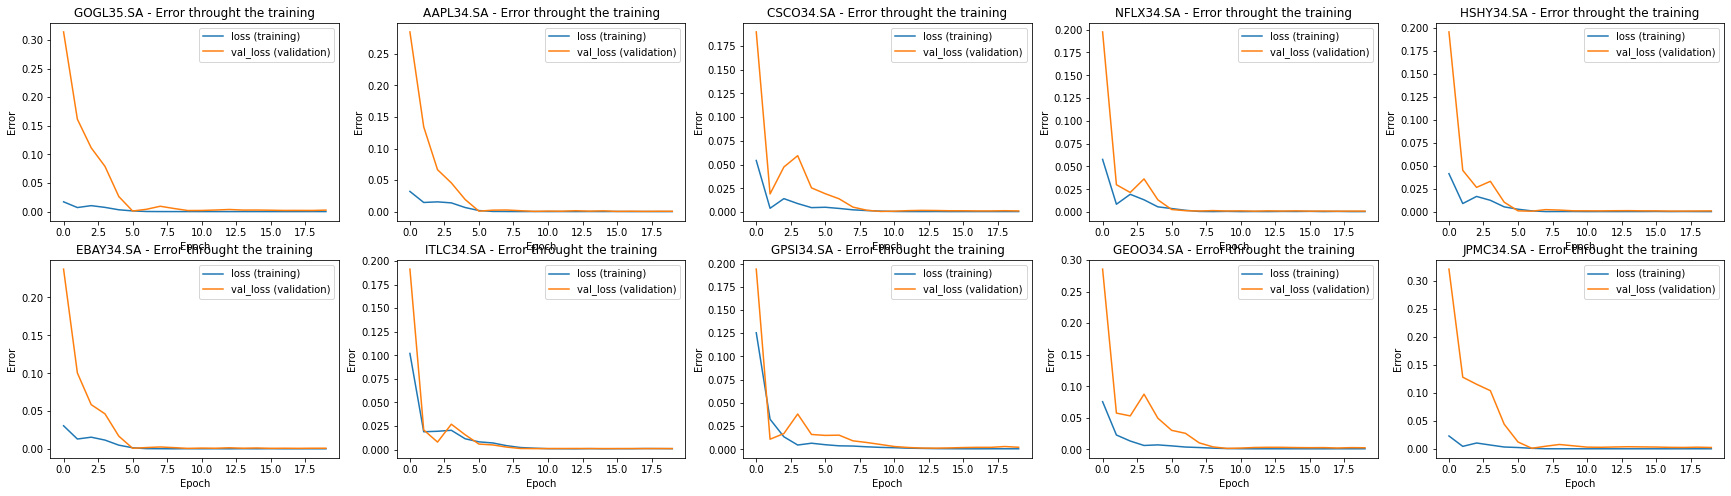

In [17]:
fig, axs = plt.subplots(2, 5)
fig.set_figwidth(30)
fig.set_figheight(8)
coords = {
    'GOGL35.SA': {'x': 0, 'y': 0}, 
    'AAPL34.SA': {'x': 0, 'y': 1}, 
    'CSCO34.SA': {'x': 0, 'y': 2}, 
    'NFLX34.SA': {'x': 0, 'y': 3}, 
    'HSHY34.SA': {'x': 0, 'y': 4}, 
    'EBAY34.SA': {'x': 1, 'y': 0}, 
    'ITLC34.SA': {'x': 1, 'y': 1}, 
    'GPSI34.SA': {'x': 1, 'y': 2}, 
    'GEOO34.SA': {'x': 1, 'y': 3},
    'JPMC34.SA': {'x': 1, 'y': 4}
}

for ticker in ticker_list:
  axs[coords[ticker]['x'], coords[ticker]['y']].plot(history[ticker].history['loss'])
  axs[coords[ticker]['x'], coords[ticker]['y']].plot(history[ticker].history['val_loss'])
  axs[coords[ticker]['x'], coords[ticker]['y']].set_title(f'{ticker} - Error throught the training')
  axs[coords[ticker]['x'], coords[ticker]['y']].set_ylabel('Error')
  axs[coords[ticker]['x'], coords[ticker]['y']].set_xlabel('Epoch')
  axs[coords[ticker]['x'], coords[ticker]['y']].legend(['loss (training)', 'val_loss (validation)'], loc='upper right')

#### testing the models predictions

In [18]:
prediction = {}

for ticker in ticker_list:
  prediction[ticker] = model[ticker].predict(test_x[ticker])


8/8 [==============================] - 1s 5ms/step


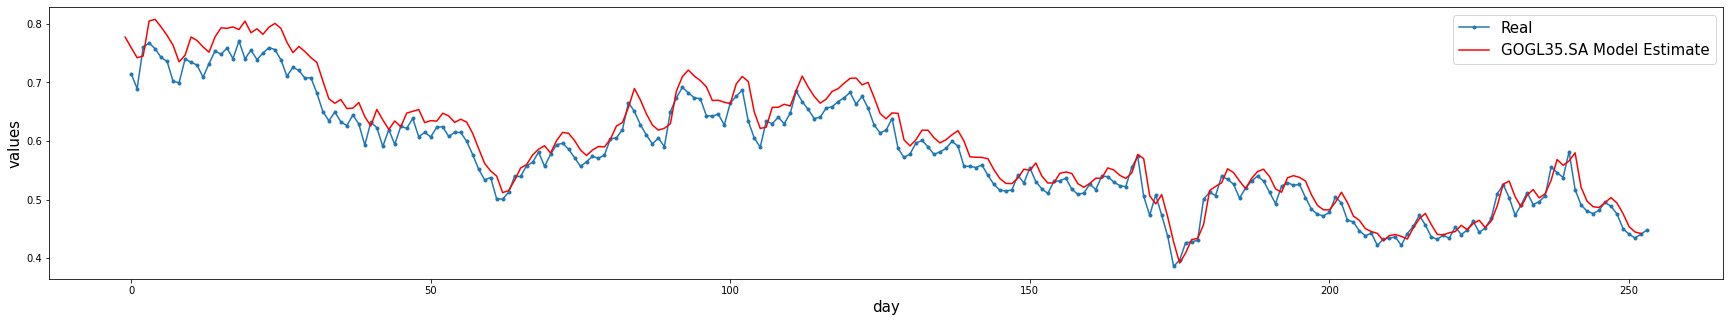

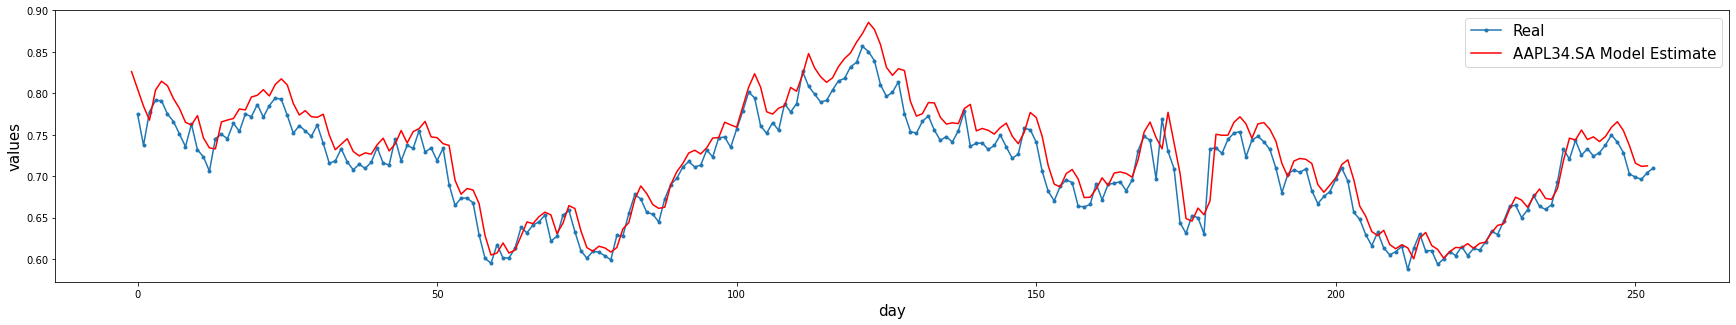

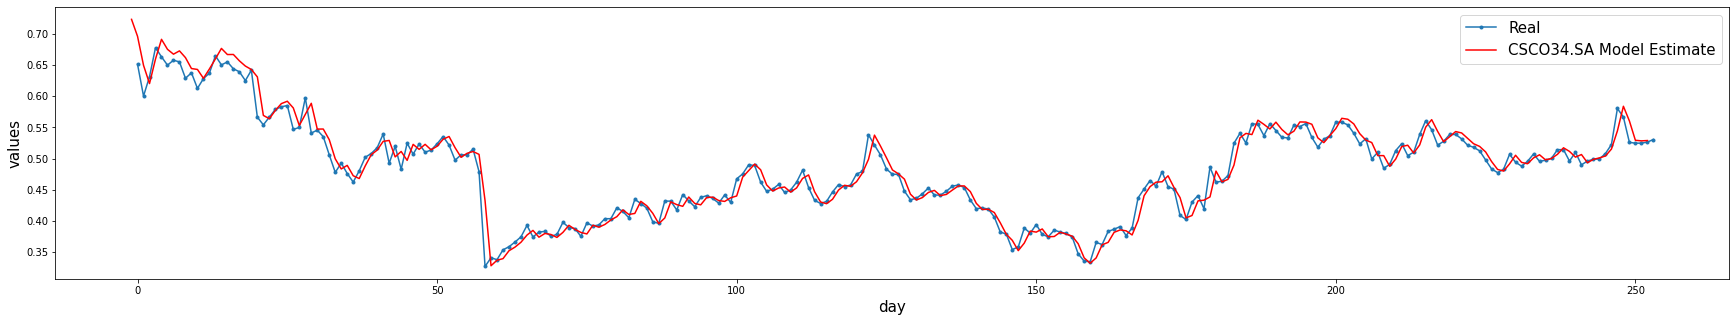

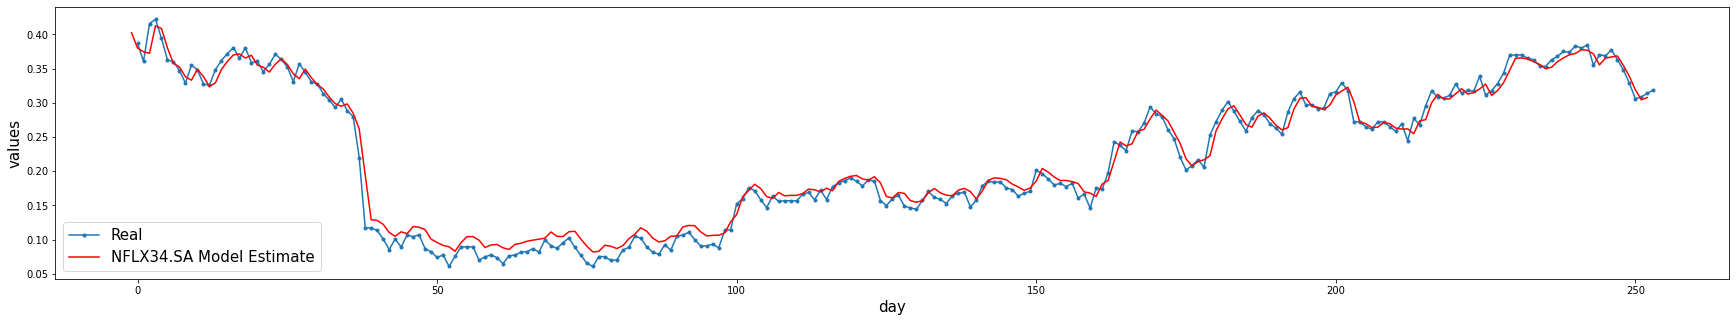

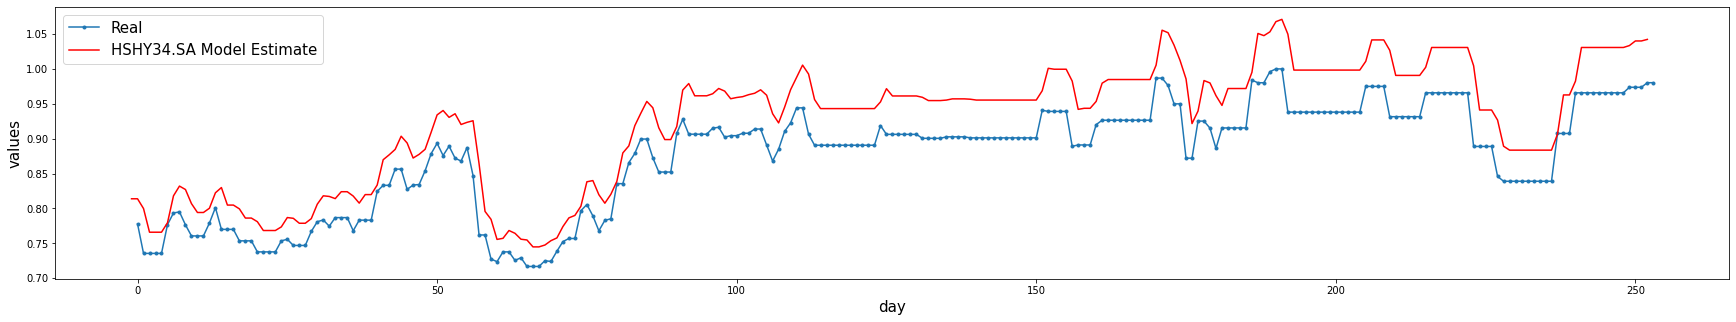

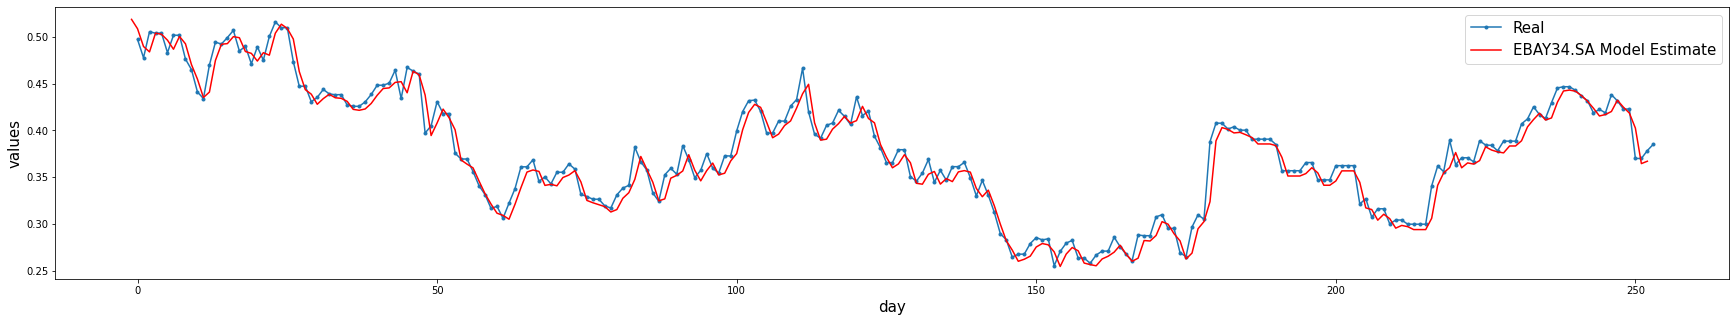

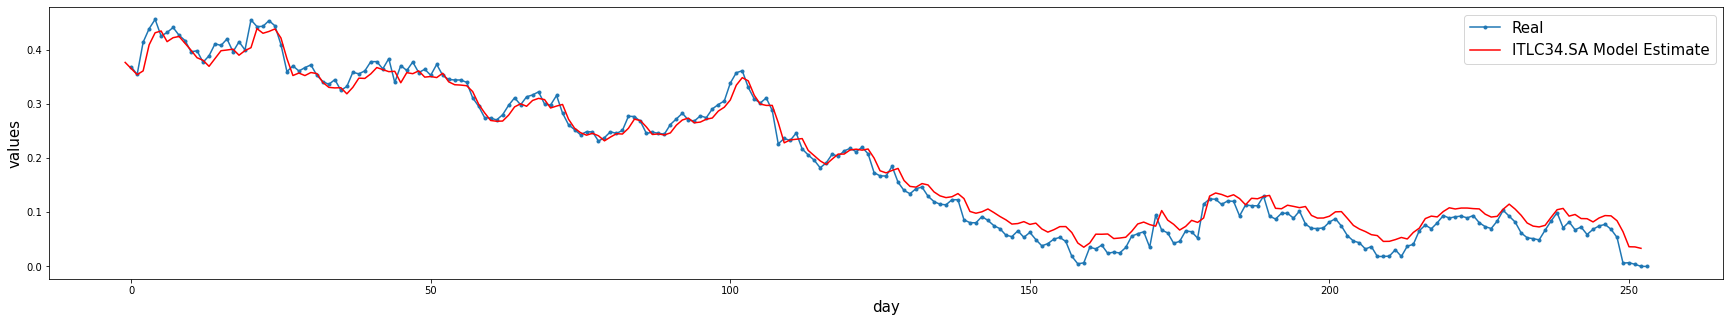

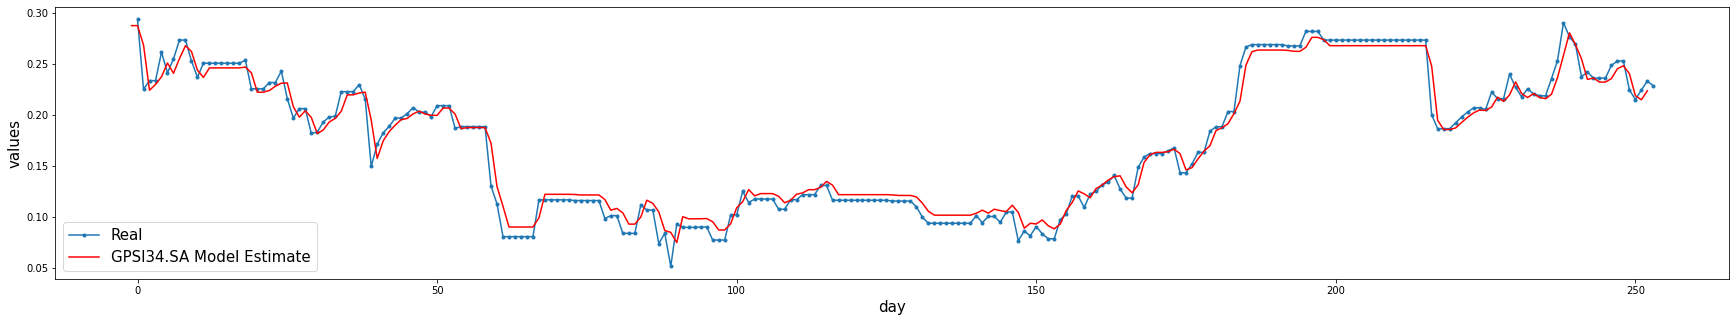

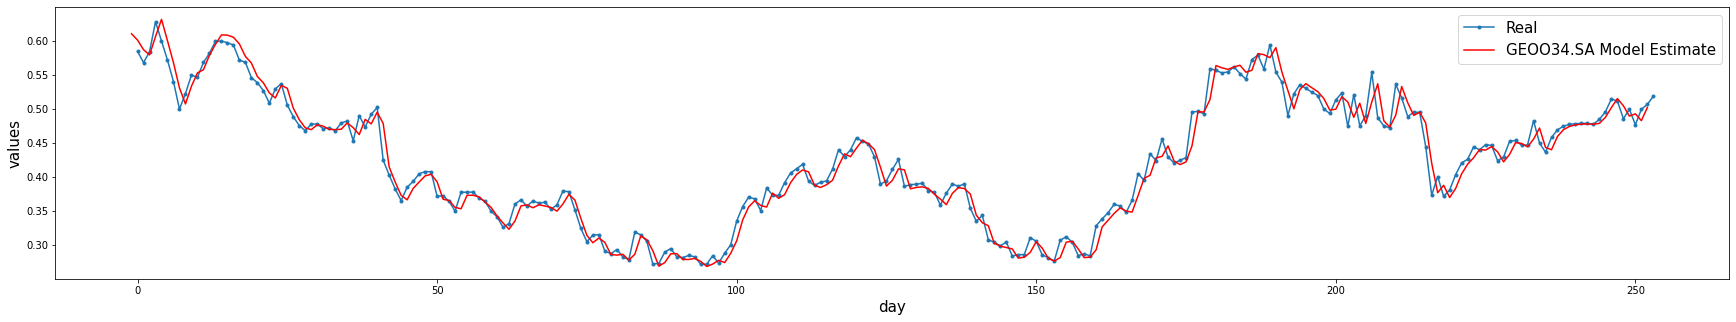

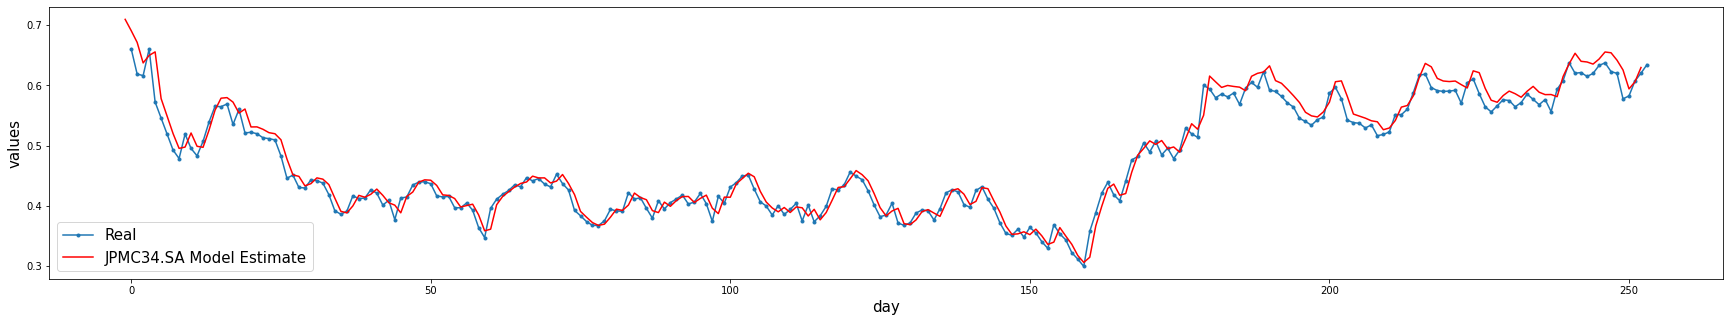

In [34]:
real_y = {}
prediction_list = {}

for ticker in ticker_list:
  look_back = 1
  real_y[ticker] = test_y[ticker]
  plt.figure(figsize=(30,5))
  plt.plot(list(range(len(real_y[ticker]))), 
          real_y[ticker], 
          marker='.', 
          label='Real')
  prediction_list[ticker] = [w[0] for w in prediction[ticker]]
  plt.plot(list(np.arange(len(prediction[ticker]))-look_back), 
          prediction_list[ticker], 
          'r',label=f'{ticker} Model Estimate')
  plt.ylabel('values', size=15)
  plt.xlabel('day', size=15)
  plt.legend(fontsize=15)
  plt.show()

In [20]:
gain = {}

for ticker in ticker_list:
  print('\n')
  tomorrow_prediciton = model[ticker].predict([test_x[ticker][-1]])
  gain[ticker] = (tomorrow_prediciton[1][0] - test_x[ticker][-1][1][0]) / tomorrow_prediciton[1][0]
  print(f'{ticker}: \n today\'s value: {test_x[ticker][-1][1][0]}  \n tomorrow prediciton: {tomorrow_prediciton[1][0]} \n gain: {(gain[ticker]) * 10:2.2f}%')



1/1 [==============================] - 1s 859ms/step


GOGL35.SA: 
 today's value: 0.4409650741061116  
 tomorrow prediciton: 0.14942029118537903 
 gain: -19.51%


1/1 [==============================] - 1s 863ms/step


AAPL34.SA: 
 today's value: 0.7044714900176533  
 tomorrow prediciton: 0.2171880453824997 
 gain: -22.44%


1/1 [==============================] - 1s 868ms/step


CSCO34.SA: 
 today's value: 0.5263377311821185  
 tomorrow prediciton: 0.17501261830329895 
 gain: -20.07%




1/1 [==============================] - 1s 850ms/step


NFLX34.SA: 
 today's value: 0.31400980440026255  
 tomorrow prediciton: 0.11502537131309509 
 gain: -17.30%




1/1 [==============================] - 1s 1s/step


HSHY34.SA: 
 today's value: 0.9802298608500283  
 tomorrow prediciton: 0.30652350187301636 
 gain: -21.98%


1/1 [==============================] - 1s 1s/step


EBAY34.SA: 
 today's value: 0.37838611456317317  
 tomorrow prediciton: 0.12792937457561493 
 gain: -19.58%


1/1 [==============================] - 2s 2s/step


ITLC34.SA: 
 today's value: 0.00023005802447831423  
 tomorrow prediciton: 0.03522678464651108 
 gain: 9.93%


1/1 [==============================] - 1s 848ms/step


GPSI34.SA: 
 today's value: 0.2329349287190725  
 tomorrow prediciton: 0.09451166540384293 
 gain: -14.65%


1/1 [==============================] - 1s 835ms/step


GEOO34.SA: 
 today's value: 0.5066999590165592  
 tomorrow prediciton: 0.1693292260169983 
 gain: -19.92%


1/1 [==============================] - 1s 867ms/step
JPMC34.SA: 
 today's value: 0.620101227745817  
 tomorrow prediciton: 0.20448333024978638 
 gain: -20.33%


We can see that the only stock predicted to increase is ITLC34.SA.

### Applying the results on the knapsack problem

Now we will use the gains above as utility values ($g_{i}$), the weights ($p_{i}$), will all be 1 and the independent term will be 3, since we want to choose only 3 stocks to invest. The problem then is:

$$max  \quad\quad z=g_{1}x_{1} + g_{2}x_{2} + g_{3}x_{3} + g_{4}x_{4} + g_{5}x_{5} + g_{6}x_{6} + g_{7}x_{7} + g_{8}x_{8} + g_{9}x_{9} + g_{10}x_{10}$$
$$s.a  \quad\quad x_{1} + x_{2} + x_{3} + x_{4} + x_{5} + x_{6} + x_{7} + x_{8} + x_{9} + x_{10} \le 3$$
$$x_{i} \in \{0, 1\}, \quad i = 1,...,10$$



In [26]:
obj_coef = list(gain.values())
rest_coef = [1] * 10
ind = 3

#### Setting up optimization model

In [27]:
size = range(len(obj_coef))
model = Model('pack')
mip_vars = [model.add_var(var_type=BINARY) for i in size]

In [28]:
obj_func = xsum(obj_coef[i] * mip_vars[i] for i in size)
model.objective = maximize(obj_func)

#### Adding the restriction

In [29]:
model += xsum(rest_coef[i] * mip_vars[i] for i in size) <= ind
print(f'The model has {model.num_cols} variable(s), {model.num_rows} restiction(s) e {model.num_nz} zero(s)')

The model has 10 variable(s), 1 restiction(s) e 10 zero(s)


#### Applying the model

In [30]:
opt_status = model.optimize(max_seconds=10)
if opt_status == OptimizationStatus.OPTIMAL:
  print('Successfully optimized')
else:
  print('Failed to optimize')

Successfully optimized


#### Results

In [33]:
selected = [list(gain.keys())[i] for i in size if mip_vars[i].x >= 0.99]
print(f'Selected items: {selected}')
print(f'Optimal return: {model.objective_value}')

Selected items: ['ITLC34.SA']
Optimal return: 0.9934692301103587


## Analysis

We can see that the knapsack model selected only one stock. That was expected, since the one it selected was the only one the RNN models predicted would go up the next day, all others had significant losses.